In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to directory provided.
%cd "/content/drive/MyDrive/Adv Machine Learning/Wrapper_Feature_Selection_Methods"

/content/drive/MyDrive/Adv Machine Learning/Wrapper_Feature_Selection_Methods


In [ ]:
from FS.GWOJA import jfs   # change this to switch algorithm

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import rand
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
sc = StandardScaler()

In [ ]:
# here X is features and y is labels
# k is the num_ of splits usally k = 3, k =5, or k = 10
def kfold(k, model, X, y):

  # prepare the cross-validation procedure
  cv = KFold(n_splits=k, random_state=1, shuffle=True)  # 10-fold cross-validation
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  acc = mean(scores)

  return acc, scores.min(), scores.max()

def k_evaluate(k,model,x , y):
  acc_list = {}
  for i in range(2, k+1):
    acc,_,_ = kfold(i, model, x, y)
    acc_list.update( {i : acc} )
    print(f"for fold: {i}, accuracy is: {acc_list.get(i)}")
  # get max
  m_key = max(acc_list, key = acc_list.get)
  print("Best fit"             )
  print(f"{m_key} gives accuracy of {acc_list.get(m_key)}")
  return acc_list.get(m_key) # acc


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']

    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc

    return error

# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

def evaluate_fn(Y_test,model_pred):
    # cm = confusion_matrix(Y_test.argmax(), model_pred.argmax())
    cm = confusion_matrix(Y_test.astype(int).tolist(), model_pred)

    True_Positives = cm[0][0]
    False_Positives = cm[0][1]

    True_Negetives = cm[1][1]
    False_Negetives = cm[1][0]

    # return True_Positives,False_Positives,False_Negetives,True_Negetives

    precision =  True_Positives / (True_Positives + False_Positives)
    recall = True_Positives / (True_Positives + False_Negetives)
    f1_score = 2*(precision * recall) / (precision + recall)

    return precision,recall,f1_score

In [ ]:
# grab our features
data = arff.loadarff("/content/drive/MyDrive/Breast.arff")
data = pd.DataFrame(data[0])
data.tail()

,Contig45645_RC,Contig44916_RC,D25272,J00129,Contig29982_RC,Contig26811,D25274,Contig36292,Contig42854,Contig34839,...,NM_000898,NM_000899,Contig20164_RC,Contig8985_RC,Contig36062_RC,Contig35333_RC,Contig62037_RC,AF067420,Contig15167_RC,Class
92,1.058,-0.037,0.053,-0.667,0.198,-0.028,-0.186,-0.005,-0.156,0.004,...,-0.236,0.058,0.018,-0.002,0.042,0.071,0.094,-0.193,-0.002,b'non-relapse'
93,0.105,0.021,0.022,-0.527,-0.286,-0.090,0.007,-0.060,-0.012,-0.005,...,-0.814,0.164,0.199,0.040,0.045,0.028,0.190,-0.687,0.089,b'non-relapse'
94,-0.167,-0.047,-0.146,-0.607,-0.482,-0.148,-0.109,-0.081,0.006,-0.109,...,-0.803,0.050,0.214,0.087,0.106,0.075,0.314,-0.978,0.244,b'non-relapse'
95,-0.195,-0.097,-0.153,-0.731,-0.432,-0.159,0.110,-0.106,-0.110,-0.052,...,-0.583,0.052,0.200,0.079,0.071,0.040,0.198,-0.130,0.361,b'non-relapse'
96,0.182,-0.081,-0.133,-0.731,-0.092,-0.134,-0.216,-0.009,-0.296,-0.027,...,-0.504,-0.039,0.059,0.353,-0.210,-0.024,0.051,-0.031,-0.035,b'non-relapse'


In [ ]:
data.columns

Index(['Contig45645_RC', 'Contig44916_RC', 'D25272', 'J00129',
       'Contig29982_RC', 'Contig26811', 'D25274', 'Contig36292', 'Contig42854',
       'Contig34839',
       ...
       'NM_000898', 'NM_000899', 'Contig20164_RC', 'Contig8985_RC',
       'Contig36062_RC', 'Contig35333_RC', 'Contig62037_RC', 'AF067420',
       'Contig15167_RC', 'Class'],
      dtype='object', length=24482)

In [ ]:
# check for any null values
data.isnull().sum()

Contig45645_RC    0
Contig44916_RC    0
D25272            0
J00129            0
Contig29982_RC    0
                 ..
Contig35333_RC    0
Contig62037_RC    0
AF067420          0
Contig15167_RC    0
Class             0
Length: 24482, dtype: int64

In [ ]:
# class values are in byte string format but we need them in integer format
# Converting them into string first
y = data.Class  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = cvt(y[st])
# print(y)

In [ ]:
# Then convert them into integer
y.replace({"non-relapse": 0, "relapse": 1}, inplace= True)

In [ ]:
# grab our features
Y = y.values
x = data.drop(['Class'], axis=1)
X = x.to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (77, 24481)
y_train shape:  (77,)
x_text:  (20, 24481)
y_test:  (20,)


In [ ]:
cols = (data.columns).to_list()
col_dict = dict(enumerate((x.columns.to_numpy()).flatten(), 0))

In [ ]:
# parameter
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
CR   = 0.8
MR   = 0.01
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}

opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}

In [ ]:
# Check for types of x and y wheather they are numpy.ndarray or not
# y = y.values
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
fmdl = jfs(x_train,y_train, opts)

Iteration: 1
Best (GWO): 0.45047242759691186
Iteration: 2
Best (GWOJA): 0.4008310935010825
Iteration: 3
Best (GWOJA): 0.4008310935010825
Iteration: 4
Best (GWOJA): 0.40029802704137907
Iteration: 5
Best (GWOJA): 0.40029802704137907
Iteration: 6
Best (GWOJA): 0.40029802704137907
Iteration: 7
Best (GWOJA): 0.40029802704137907
Iteration: 8
Best (GWOJA): 0.40000024508802745
Iteration: 9
Best (GWOJA): 0.39987361627384505
Iteration: 10
Best (GWOJA): 0.39979477962501536
Iteration: 11
Best (GWOJA): 0.39974902985989136
Iteration: 12
Best (GWOJA): 0.3997171684163229
Iteration: 13
Best (GWOJA): 0.3996820391323884
Iteration: 14
Best (GWOJA): 0.39961096360442794
Iteration: 15
Best (GWOJA): 0.3994708549487358
Iteration: 16
Best (GWOJA): 0.39934749397491937
Iteration: 17
Best (GWOJA): 0.3992555859646256
Iteration: 18
Best (GWOJA): 0.39921351251991344
Iteration: 19
Best (GWOJA): 0.39915346595318824
Iteration: 20
Best (GWOJA): 0.3990488950614763
Iteration: 21
Best (GWOJA): 0.3989414648094441
Iteration: 

NameError: name 'sf' is not defined

In [ ]:
f = fmdl['sf']
print("Lenght of features: ", len(f))
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
cor = data[features].corr()

Lenght of features:  3881


In [ ]:
new_X = x[features]
new_X.head()

,D25274,Contig36292,Contig29373_RC,Contig19662_RC,Contig46366_RC,zero_barcode,one_barcode,Contig42006_RC,Contig732_RC,Contig34362_RC,...,Contig30718_RC,Contig28660_RC,NM_000878,NM_018990,NM_018996,NM_000884,NM_000888,NM_000890,NM_000899,Contig36062_RC
0,0.039,-0.409,0.146,-0.069,0.086,-0.007,0.259,0.021,0.246,0.080,...,-0.038,-0.030,0.096,0.301,0.069,-0.261,-0.442,0.399,-0.211,-0.025
1,0.098,-0.090,0.101,0.077,0.058,-0.086,0.122,-0.182,0.170,0.051,...,-0.017,0.051,-0.182,-0.051,0.099,-0.143,-0.126,0.358,-0.020,0.148
2,0.102,0.023,0.108,0.021,-0.110,0.057,-0.010,-0.055,0.189,0.065,...,0.035,-0.205,-0.132,0.079,-0.084,-0.267,-0.364,0.337,-0.159,-0.086
3,-0.145,-0.103,0.323,0.156,-0.040,0.008,0.233,0.127,0.049,-0.067,...,0.033,0.246,-0.102,-0.049,-0.057,-0.413,0.415,-0.001,-0.096,0.076
4,0.101,-0.008,0.016,0.012,-0.036,0.063,-0.158,-0.216,-0.044,-0.013,...,0.033,0.138,-0.252,-0.001,0.191,-0.155,-0.405,-0.046,-0.088,-0.124


In [ ]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_X, Y, test_size = 0.3, random_state = 101)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",X_test.shape)
print("y_test: ",y_test.shape)

x_train shape:  (67, 3881)
y_train shape:  (67,)
x_text:  (30, 3881)
y_test:  (30,)


In [ ]:
from sklearn.preprocessing import StandardScaler

sc  = StandardScaler()
sc.fit_transform(X_train)
sc.fit(X_test)

StandardScaler()

# Classfication

## SVM

[[15  0]
 [15  0]]


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        15
           1       0.00      0.00      0.00        15

    accuracy                           0.50        30
   macro avg       0.25      0.50      0.33        30
weighted avg       0.25      0.50      0.33        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


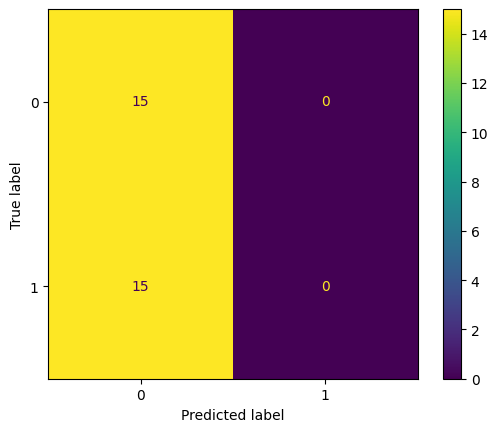

In [ ]:
model_SVC= SVC()
model_SVC.fit(X_train,y_train)
model_pred = model_SVC.predict(X_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()
print(classification_report(y_test,model_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold

acc = k_evaluate(10, model_SVC, new_X, y)

precision :  1.0 
 recall : 0.5 
 f1_score : 0.6666666666666666
for fold: 2, accuracy is: 0.39200680272108845
for fold: 3, accuracy is: 0.4131944444444444
for fold: 4, accuracy is: 0.42125
for fold: 5, accuracy is: 0.4026315789473684
for fold: 6, accuracy is: 0.44178921568627455
for fold: 7, accuracy is: 0.5251177394034537
for fold: 8, accuracy is: 0.421474358974359
for fold: 9, accuracy is: 0.43131313131313126
for fold: 10, accuracy is: 0.46111111111111114
Best fit
7 gives accuracy of 0.5251177394034537


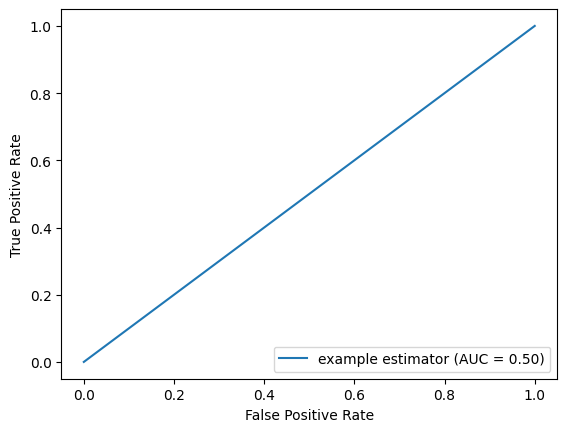

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, model_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## Naive Bayes

[[10  5]
 [13  2]]


              precision    recall  f1-score   support

           0       0.43      0.67      0.53        15
           1       0.29      0.13      0.18        15

    accuracy                           0.40        30
   macro avg       0.36      0.40      0.35        30
weighted avg       0.36      0.40      0.35        30



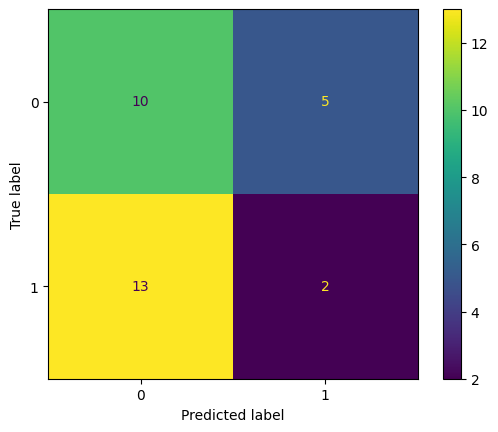

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_X, y)

precision :  0.6666666666666666 
 recall : 0.43478260869565216 
 f1_score : 0.5263157894736841
for fold: 2, accuracy is: 0.5671768707482994
for fold: 3, accuracy is: 0.5154671717171717
for fold: 4, accuracy is: 0.5054166666666666
for fold: 5, accuracy is: 0.5136842105263157
for fold: 6, accuracy is: 0.5055147058823529
for fold: 7, accuracy is: 0.5039246467817896
for fold: 8, accuracy is: 0.4959935897435898
for fold: 9, accuracy is: 0.48989898989899
for fold: 10, accuracy is: 0.4988888888888889
Best fit
2 gives accuracy of 0.5671768707482994


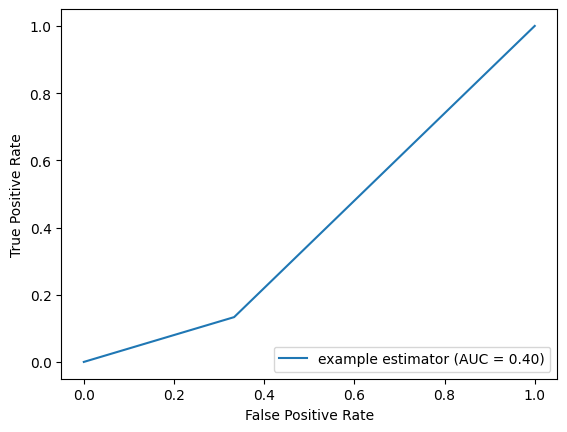

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## **DT**

[[ 7  8]
 [ 4 11]]


              precision    recall  f1-score   support

           0       0.64      0.47      0.54        15
           1       0.58      0.73      0.65        15

    accuracy                           0.60        30
   macro avg       0.61      0.60      0.59        30
weighted avg       0.61      0.60      0.59        30



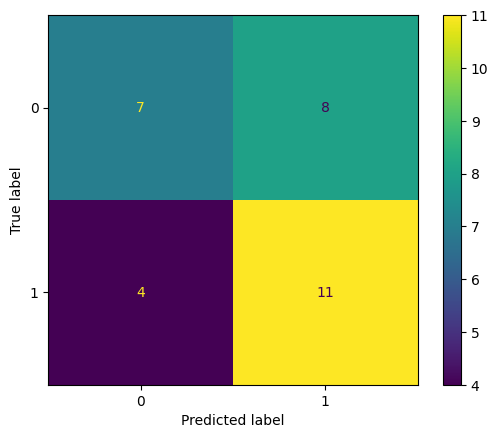

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
cm = confusion_matrix(y_test,dt_pred)
print(cm)
print('\n')
print(classification_report(y_test,dt_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, dt, new_X, y)

precision :  0.4666666666666667 
 recall : 0.6363636363636364 
 f1_score : 0.5384615384615385


for fold: 2, accuracy is: 0.5348639455782312
for fold: 3, accuracy is: 0.514520202020202
for fold: 4, accuracy is: 0.5458333333333333
for fold: 5, accuracy is: 0.5268421052631578
for fold: 6, accuracy is: 0.5147058823529412
for fold: 7, accuracy is: 0.6067503924646782
for fold: 8, accuracy is: 0.5849358974358975
for fold: 9, accuracy is: 0.5454545454545454
for fold: 10, accuracy is: 0.5555555555555556
Best fit
7 gives accuracy of 0.6067503924646782


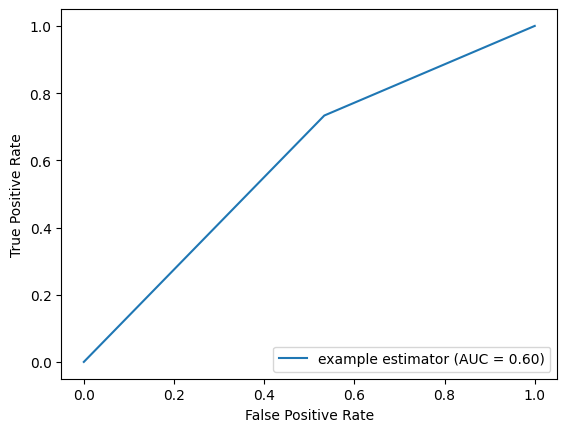

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, dt_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## Random Forest

[[ 9  6]
 [ 5 10]]


              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.62      0.67      0.65        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



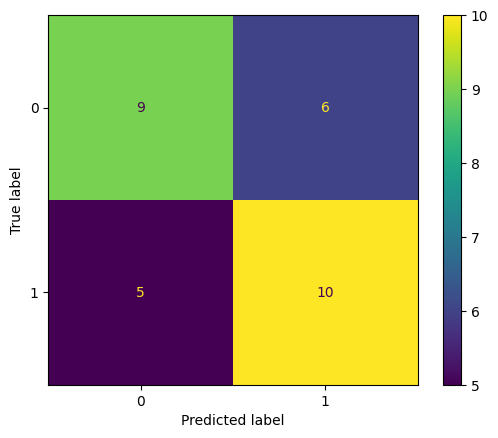

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)


cm = confusion_matrix(y_test,rf_pred)
print(cm)
print('\n')
print(classification_report(y_test,rf_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, rf_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier,new_X, y)

precision :  0.6 
 recall : 0.6428571428571429 
 f1_score : 0.6206896551724138


for fold: 2, accuracy is: 0.5767431972789117
for fold: 3, accuracy is: 0.6174242424242424
for fold: 4, accuracy is: 0.71125
for fold: 5, accuracy is: 0.5678947368421052
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.6899529042386187
for fold: 8, accuracy is: 0.6153846153846154
for fold: 9, accuracy is: 0.5848484848484848
for fold: 10, accuracy is: 0.6677777777777777
Best fit
4 gives accuracy of 0.71125


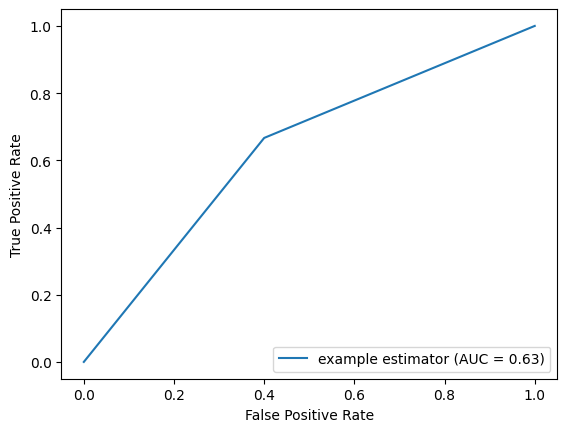

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

## LDA

[[ 9  6]
 [ 5 10]]


              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



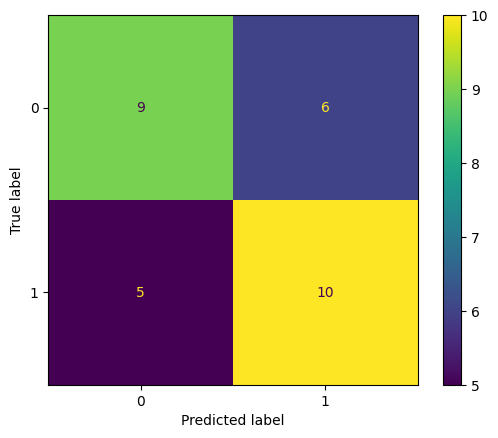

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
lda_pred = lda.predict(X_test)
confusion_matrix(y_test,lda_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print('\n')
print(classification_report(y_test,lda_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

#Kfold
acc = k_evaluate(10,lda, new_X, y)  # here k 10

precision :  0.6666666666666666 
 recall : 0.625 
 f1_score : 0.6451612903225806
for fold: 2, accuracy is: 0.6175595238095238
for fold: 3, accuracy is: 0.5978535353535354
for fold: 4, accuracy is: 0.6395833333333333
for fold: 5, accuracy is: 0.5468421052631579
for fold: 6, accuracy is: 0.6495098039215687
for fold: 7, accuracy is: 0.6271585557299844
for fold: 8, accuracy is: 0.6482371794871795
for fold: 9, accuracy is: 0.6545454545454545
for fold: 10, accuracy is: 0.6077777777777778
Best fit
9 gives accuracy of 0.6545454545454545


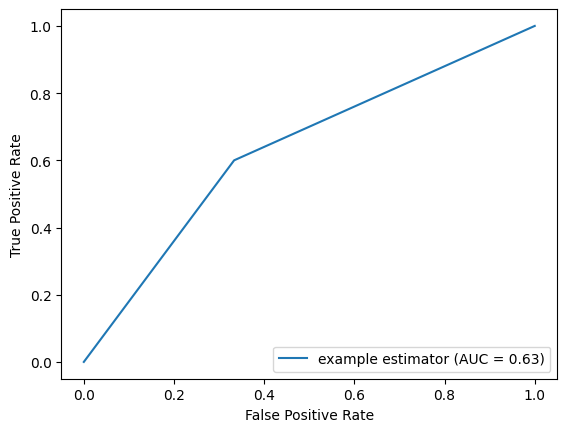

In [ ]:
# find fpr(False positive rate), tpr(True positive rate)
fpr, tpr, thresholds = roc_curve(y_test, lda_pred)
# calculate Area under ROC curve. If None, the roc_auc score is not shown.
roc_auc = auc(fpr, tpr)

display =RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()